<h1 style="font-size: 48px; color: red;">Classification à partir de la base de données My Anime List</h1>

<h1 style="font-size: 32px; color: green;">Partie I : Récupération des données à partir de l'API de MyAnimeList puis nettoyage des données</h1>

Cliquez [ici](https://myanimelist.net/apiconfig/references/api/v2) pour accéder au site de l'API

<h1 style="font-size: 22px; color: blue;">1/Récupération des données à partir de l'API de MyAnimeList</h1>


In [60]:
import requests
import pandas as pd
import ast

#Comme l'API ne nous permet pas de récupérer les animes en groupe à travers leur ID, on récupère la liste des animés et leur caractéristiques à partir de leur le rang, dans l'ordre décroissant décroissant (en prenant les 100 1ers rangs, puis les 100 rangs suivants ainsi de suite...)

all_anime = [] 
nbr_needed = 27490  #Total number of anime on MAL as of 13/11/2024 (obtained by looking directly on the site of myanimelist)

ID = {'X-MAL-CLIENT-ID': 'c2db532c391bf31339ffd6afa650d528'} #id client obtenu après s'être inscrit sur My Anime List et avoir fait une demande
url = 'https://api.myanimelist.net/v2/anime/ranking'
parameters = {
    'ranking_type': 'all',  
    'limit': 100,  # Max limit per request, divides the total number of anime on mal
    'fields': 'id,title,mean,start_date,end_date,rank,popularity,num_list_users,num_scoring_users,nsfw,media_type,status,num_episodes,start_season,broadcast,source,average_episode_duration,rating'
}

k = 0  # offset but also the number of times the loop is used that is 27490/100 here

# Loop until we've collected the target number of anime
while k < nbr_needed:
    parameters['offset'] = k
    mal = requests.get(url, headers=ID, params=parameters)

    
    if mal.status_code == 200: # Check if the request is successful
        data = mal.json()
        all_anime.extend(data['data'])
        k += parameters['limit']

        print(str(len(all_anime)) + " collected for the moment...")
    
        if len(all_anime) >= nbr_needed:
            print("the total number of anime collected is " + str(len(all_anime)))
            break
    else :
        print("cannot retrieve more than " + str(len(all_anime))) 
        break

anime_data = pd.DataFrame(all_anime) 
print(anime_data.head(2))

print(anime_data.head())
print(anime_data.info())

#On voit que le dataframe est constitué du rang des animé et d'un "node", un dictionnaire qui contient toutes les caractéristiques de chaque anime.
#Il faut donc extraire chaque élément du dictionnaire node pour en faire des colonnes à part entière

# On extrait toutes les clés du dictionnaire 'node' et on les transforme en colonnes du dataframe
anime_data['node'] = anime_data['node'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)    
keys = set().union(*(d.keys() for d in anime_data['node'] if isinstance(d, dict)))
for y in keys:
    anime_data[f'{y}'] = anime_data['node'].apply(lambda x: x.get(y) if isinstance(x, dict) else None)

# On convertit les colonnes contenant des dictionnaires en chaînes
for column in anime_data.columns:
    if anime_data[column].map(type).eq(dict).any():
        anime_data[column] = anime_data[column].apply(lambda x: str(x) if isinstance(x, dict) else x)

print(anime_data.head())

#On supprime la colonne node qui n'apporte plus d'info
anime_data = anime_data.drop(columns=['node'])

100 collected for the moment...
200 collected for the moment...
300 collected for the moment...
400 collected for the moment...
500 collected for the moment...
600 collected for the moment...
700 collected for the moment...
800 collected for the moment...
900 collected for the moment...
1000 collected for the moment...
1100 collected for the moment...
1200 collected for the moment...
1300 collected for the moment...
1400 collected for the moment...
1500 collected for the moment...
1600 collected for the moment...
1700 collected for the moment...
1800 collected for the moment...
1900 collected for the moment...
2000 collected for the moment...
2100 collected for the moment...
2200 collected for the moment...
2300 collected for the moment...
2400 collected for the moment...
2500 collected for the moment...
2600 collected for the moment...
2700 collected for the moment...
2800 collected for the moment...
2900 collected for the moment...
3000 collected for the moment...
3100 collected for 

12900 collected for the moment...
13000 collected for the moment...
13100 collected for the moment...
13200 collected for the moment...
13300 collected for the moment...
13400 collected for the moment...
13500 collected for the moment...
13600 collected for the moment...
13700 collected for the moment...
13800 collected for the moment...
13900 collected for the moment...
14000 collected for the moment...
14100 collected for the moment...
14200 collected for the moment...
14300 collected for the moment...
14400 collected for the moment...
14500 collected for the moment...
14600 collected for the moment...
14700 collected for the moment...
14800 collected for the moment...
14900 collected for the moment...
15000 collected for the moment...
15100 collected for the moment...
15200 collected for the moment...
cannot retrieve more than 15200
                                                node      ranking
0  {'id': 52991, 'title': 'Sousou no Frieren', 'm...  {'rank': 1}
1  {'id': 5114, 'tit

<h1 style="font-size: 22px; color: blue;">2/Nettoyage des données et enregistrement du dataframe en fichier csv</h1>


In [61]:
#On vérifie s'il y a des doublons
nbr_doublons = anime_data.duplicated().sum()
print(f"Il y a {nbr_doublons} doublons")

#On supprime les colonnes qui ne serviront pas pour la recommendation
anime_data=anime_data.drop(columns=['main_picture','broadcast','start_season','end_date'],axis=1)
pd.set_option('display.max_columns', None)
print(anime_data.head())

#On regarde combien de valeurs NaN il y a dans chaque colonne
for i in anime_data.columns:
    k = anime_data[i].isna().sum()
    print(f"Le nombre de NaN dans la colonne '{i}' est : {k}")

#On gère les différents types de NaN
anime_data['source'] = anime_data['source'].fillna('source_inconnue')
anime_data['rating'] = anime_data['source'].fillna('rating_inconnu')
anime_data['mean'] = anime_data['mean'].fillna(0)
anime_data = anime_data.dropna(subset=['rank'])

#On veut uniquement garder l'année dans la colonne start_date
anime_data['start_date'] = pd.to_datetime(anime_data['start_date'], errors='coerce')  
anime_data['start_year'] = anime_data['start_date'].dt.year  
anime_data=anime_data.drop(columns=['start_date'],axis=1)

anime_data = anime_data.dropna(subset=['start_year'])

#On vérifie qu'il n'y a plus de NaN
nbr_nan = anime_data.isna().sum().sum()
print(f"Il reste {nbr_nan} NaN")

#On ne garde que les colonnes numériques pour calculer la matrice de correlation
anime_data_num = anime_data.select_dtypes(include=["number"])
# Calcul de la matrice de corrélation
print(anime_data_num.corr())

#On sauvegarde le DataFrame en fichier CSV local
local_file_path = "anime_data.csv"
anime_data.to_csv(local_file_path, index=False)
print(f"Fichier CSV sauvegardé localement : {local_file_path}")


Il y a 0 doublons
       ranking  media_type     id  popularity  rank  num_scoring_users  \
0  {'rank': 1}          tv  52991         173     1             564221   
1  {'rank': 2}          tv   5114           3     2            2179980   
2  {'rank': 3}  tv_special  60022        2613     3              57937   
3  {'rank': 4}          tv   9253          14     4            1439183   
4  {'rank': 5}          tv  38524          21     5            1653433   

                                title  mean rating   nsfw  num_episodes  \
0                   Sousou no Frieren  9.32  pg_13  white            28   
1    Fullmetal Alchemist: Brotherhood  9.10      r  white            64   
2                One Piece Fan Letter  9.08  pg_13  white             1   
3                         Steins;Gate  9.07  pg_13  white            24   
4  Shingeki no Kyojin Season 3 Part 2  9.05      r  white            10   

   num_list_users        source  average_episode_duration  start_date  \
0          97

<h1 style="font-size: 32px; color: green;">Partie II : Etudes des données et quelques visualisations</h1>


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<h1 style="font-size: 22px; color: blue;">1/Familiarisation avec les données</h1>


In [63]:
#On cherche à voir à quoi ressemble les données obtenues sur les animés
print(anime_data.head())
print(anime_data.describe())
print(anime_data.dtypes)

       ranking  media_type     id  popularity  rank  num_scoring_users  \
0  {'rank': 1}          tv  52991         173     1             564221   
1  {'rank': 2}          tv   5114           3     2            2179980   
2  {'rank': 3}  tv_special  60022        2613     3              57937   
3  {'rank': 4}          tv   9253          14     4            1439183   
4  {'rank': 5}          tv  38524          21     5            1653433   

                                title  mean        rating   nsfw  \
0                   Sousou no Frieren  9.32         manga  white   
1    Fullmetal Alchemist: Brotherhood  9.10         manga  white   
2                One Piece Fan Letter  9.08   light_novel  white   
3                         Steins;Gate  9.07  visual_novel  white   
4  Shingeki no Kyojin Season 3 Part 2  9.05         manga  white   

   num_episodes  num_list_users        source  average_episode_duration  \
0            28          979356         manga                      1470

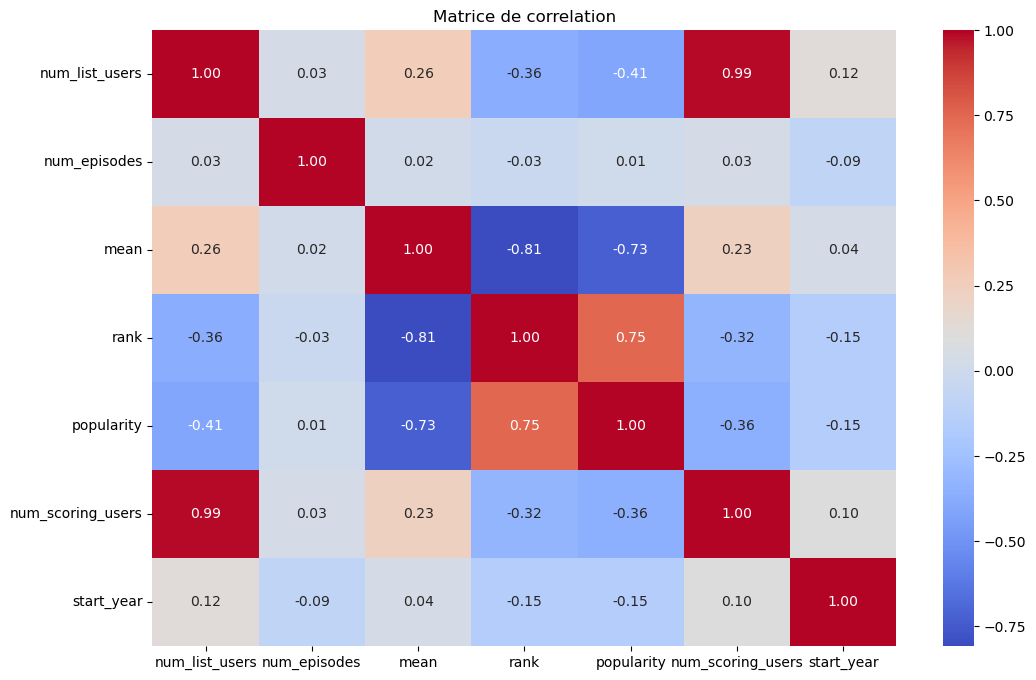

<Figure size 640x480 with 0 Axes>

In [64]:
#On regarde la matrice de corrélation

numerical_features = ['num_list_users', 'num_episodes', 'mean', 'rank', 'popularity', 'num_scoring_users', 'start_year']
plt.figure(figsize=(12, 8))
correlation_matrix = anime_data[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de correlation')
plt.show()
plt.savefig('matrice_de_co.png')

<h1 style="font-size: 22px; color: blue;">2/Etude approfondie des données</h1>

On cherche ici à tester et visualiser quelques intuitions qu'on pourrait avoir vis-à-vis des données


In [65]:
#On va utiliser la caractéristique note moyenne des utilisateurs pour un animé dans nos études
#Or, comme une note moyenne des utilisateurs pour un anime donné était mise à 0 quand elle était inconnue (NaN), on va supprimer les animes dont la note moyenne est 0.
#De manière intuitive, il est normal de supprimer ces animes car une note moyenne par les utilisateurs de 0 est quasi impossible

print(anime_data['mean'].describe()) #On voit bien une surreprésentation des animés avec une note moyenne des utilisateurs de 0

anime_data_for_score=anime_data[anime_data['mean'] !=0] #On vient de créer un dataframe qui ne prendra pas en compte les animés avec une note moyenne des utilisateurs de 0 lorsqu'on utilisera cette même caractéristique.
print(anime_data_for_score['mean'].describe())

anime_data['start_year'].value_counts().sort_index()

count    13705.000000
mean         6.185566
std          1.813732
min          0.000000
25%          5.880000
50%          6.520000
75%          7.180000
max          9.320000
Name: mean, dtype: float64
count    12836.00000
mean         6.60433
std          0.86399
min          1.88000
25%          6.02000
50%          6.60000
75%          7.22000
max          9.32000
Name: mean, dtype: float64


start_year
1917.0      5
1918.0      6
1926.0      1
1927.0      2
1928.0      1
         ... 
2020.0    504
2021.0    589
2022.0    548
2023.0    584
2024.0    457
Name: count, Length: 90, dtype: int64

In [66]:
#1/On pense que la distribution du nombre d'animés en fonction de leur note moyenne est une courbe en cloche centré autour de 5. 
#Pour vérifier cette hypothèse, on fait un histogramme qui représente le nombre d'animes par note moyenne.
plt.figure(figsize=(10, 6))
sns.histplot(anime_data_for_score['mean'], bins=30, kde=True, color='blue')
plt.title("Distribution des animes en fonction de leurs notes moyennes")
plt.xlabel("Note moyenne")
plt.ylabel("Nbr d'animes")
plt.savefig("Nbr_animés_par_note_moyenne.png")
plt.close()

In [67]:
#2/On pense que la production d'animés n'a cessé d'augmenter avec le temps. 
#Pour vérifier notre intuition, on représente l'évolution du nombre d'animes produits par année à l'aide d'un histogramme
plt.figure(figsize=(12, 6))
sns.countplot(x='start_year', data=anime_data, palette='viridis', hue='start_year', legend=False)
plt.xticks(rotation=90)
plt.title("Nombre d'animes produits par année")
plt.xlabel("Année de sortie")
plt.ylabel("Nbr d'animés")
plt.savefig("Nbr_animés_par_annee.png")
plt.close()

In [68]:
#3/On veut savoir si une source est plus prolifique en animes que d'autres. 
#Pour cela, on créé un histogramme qui représente le nombre d'animes en fonction de la source dont ils sont inspirés
plt.figure(figsize=(10, 6))
source_counts = anime_data['source'].value_counts()
sns.barplot(x=source_counts.index, y=source_counts.values, palette='coolwarm', hue=source_counts.index, legend=False)
plt.xticks(rotation=90)
plt.title("Nbr d'animes par sources'")
plt.xlabel("Source")
plt.ylabel("Nombre d'animés")
plt.savefig("Nbr_animes_par_source.png")
plt.close()

In [69]:
#4/On veut savoir si une source est plus susceptibles de produire des animés bien notés que d'autres. 
#Pour cela on fait un histogramme qui représente la note moyenne des animés d'une même source en fonction de cette source.
mean_scores_by_source = anime_data_for_score.groupby('source')['mean'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
mean_scores_by_source.plot(kind='bar', color='skyblue')
plt.title("Notes moyennes par source")
plt.xlabel("Source")
plt.ylabel("Note moyenne")
plt.savefig("Notes_moyennes_par_source.png")
plt.close()

In [70]:
#5/On veut savoir si le nombre d'utilisateurs qui a noté un anime en particulier influence la note moyenne de cette animé. 
#Pour voir cela, on fait un nuage de points dont les points sont la note moyenne d'un anime en fonction du nombre d'utilisateurs qui ont noté cette animé.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_list_users', y='mean', data=anime_data_for_score, alpha=0.6)
plt.title("Relation entre le nombre d'utilisateurs et la note moyenne")
plt.xlabel("Nombre d'utilisateurs ayant noté")
plt.ylabel("Note moyenne")
plt.xscale('log')  # On utilise une échelle logarithmique pour mieux visualiser
plt.savefig("relation_ entre_nbr_utilisateurs_et_notes_moyennes.png")
plt.close()

In [71]:
#6/On veut comparer le score moyen des animes regroupés par rang (par exemple : rang 1 à 100 puis rang 101 à 200, etc,...).
#Pour cela, on va créer 10 groupes de 100 animés

anime_data_for_score['Groupe'] = (anime_data_for_score['rank'] - 1) // 100 + 1 #on créé les groupes de 100 animés
anime_1000 = anime_data_for_score[anime_data_for_score['Groupe'] <= 10] #on ne garde que les 10 premiers groupes

grouped_means = anime_1000.groupby('Groupe')['mean'].mean().reset_index()
grouped_means['Groupe'] = grouped_means['Groupe'].astype(str)  # Conversion pour le graphique

plt.figure(figsize=(12, 6))
sns.barplot(x='Groupe', y='mean', data=grouped_means, palette='viridis')
plt.title("Scores moyens des animes par groupe de rangs (sans scores nuls)")
plt.xlabel("Groupe de rangs (par 100)")
plt.ylabel("Score moyen")
plt.savefig("scores_moyens_par_100_rangs.png")
plt.close()


/tmp/ipykernel_46329/298248790.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_data_for_score['Groupe'] = (anime_data_for_score['rank'] - 1) // 100 + 1 #on créé les groupes de 100 animés
/tmp/ipykernel_46329/298248790.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Groupe', y='mean', data=grouped_means, palette='viridis')


In [72]:
#7/On veut voir si animés sont mieux notés d'une année sur l'autre. 
#Pour cela, on fait un courbe dont chaque point est la moyenne des notes moyennes des animés d'une année en fonction de l'année
mean_score_by_year = anime_data_for_score.groupby('start_year')['mean'].mean()
plt.figure(figsize=(12, 6))
mean_score_by_year.plot(kind='line', color='green', marker='o')
plt.title("Évolution des notes moyennes des animes au fil des années")
plt.xlabel("Année")
plt.ylabel("Note moyenne")
plt.savefig("evolution_notes_moyennes_par_annee.png")
plt.close()


In [73]:
#8/La durée d'un épisode est généralement de 20 minutes (par expérience). 
#On veut vérifier si cette intuition est vraie. Pour cela, on réalise un histogramme.

anime_data['average_episode_duration']=anime_data['average_episode_duration']/60

plt.figure(figsize=(10, 6))
sns.histplot(anime_data['average_episode_duration'].dropna(), bins=30, kde=True, color='purple')
plt.title("Nbr d'animés en fonction de la durée moyenne de leurs épisodes")
plt.xlabel("Durée moyenne des épisodes (en minutes)")
plt.ylabel("Nbr d'animés")

x_ticks = np.arange(0, anime_data['average_episode_duration'].max() + 10, 5)  # de 0 à max+10 par pas de 5 minutes
plt.xticks(x_ticks)

plt.savefig("Nbr_animés_en_fct_durée_ep.png")
plt.close()

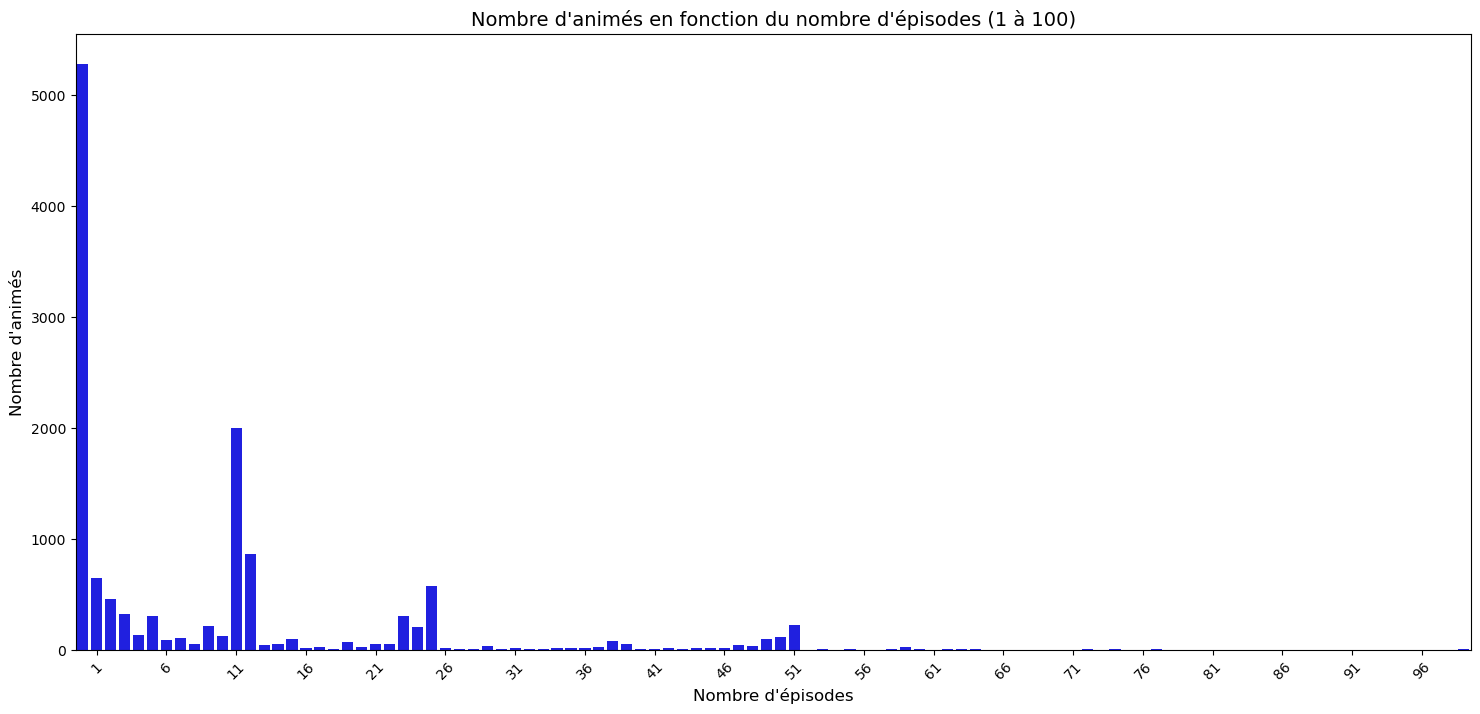

In [74]:
#9/On s'attend à ce que la plupart des animés ont 12 ou 24 épisodes. 
#Pour vérifier cette intuition, on fait un histogramme qui représente le nbr d'animés en fonction de leur nombres d'épisodes (si le nbr d'épisodes est de plus de 100, il ne sera pas représenté, car peu d'animés valident cette condition et ce sont des anomalies)

anime_filtered = anime_data[anime_data['num_episodes'].between(1, 100)]

episode_counts = anime_filtered['num_episodes'].value_counts().reindex(range(1, 101), fill_value=0).sort_index()

plt.figure(figsize=(18, 8))
sns.barplot(x=episode_counts.index, y=episode_counts.values, color='blue')

plt.title("Nombre d'animés en fonction du nombre d'épisodes (1 à 100)", fontsize=14)
plt.xlabel("Nombre d'épisodes", fontsize=12)
plt.ylabel("Nombre d'animés", fontsize=12)

plt.xticks(ticks=range(1, 101, 5), labels=range(1, 101, 5), rotation=45)  # Ticks tous les 5 pour la lisibilité

plt.savefig("nbr_animes_par_nombre_episodes_1_to_100.png", dpi=300)

<h1 style="font-size: 22px; color: blue;">3/Analyse de la popularité (la variable qui va être prédit à l'aide de notre classification) en fonction de diverses variables</h1>


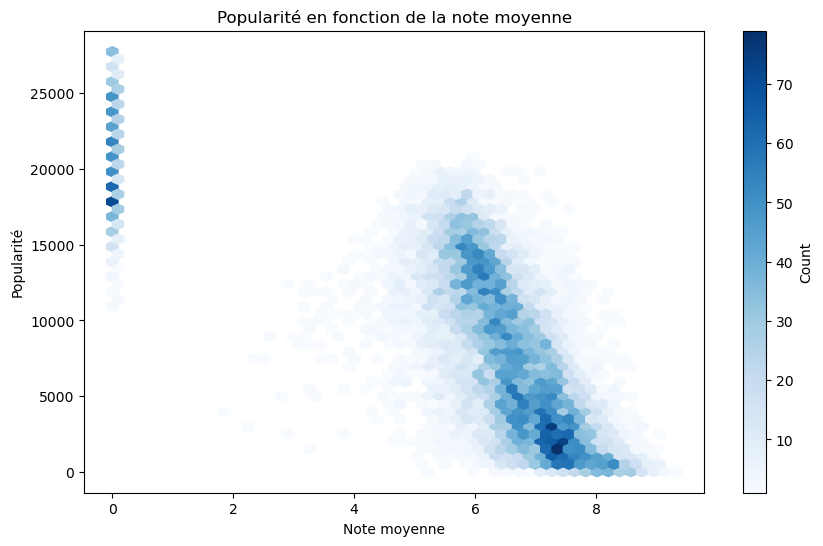

<Figure size 640x480 with 0 Axes>

In [75]:
#1/Popularité en fonction des moyennes des notes
#Lors de l'analyse exploratoire (notamment avec la matrice de corrélation), nous avons constaté une corrélation significative entre la popularité et les moyennes des notes.
plt.figure(figsize=(10, 6))
plt.hexbin(x=anime_data['mean'], y=anime_data['popularity'], gridsize=50, cmap='Blues', mincnt=1)
plt.colorbar(label='Count')
plt.title('Popularité (rang) en fonction de la note moyenne')
plt.xlabel('Note moyenne')
plt.ylabel('Popularité (rang)')
plt.show()
plt.savefig('pop_en_fct_note_moyenne.png')

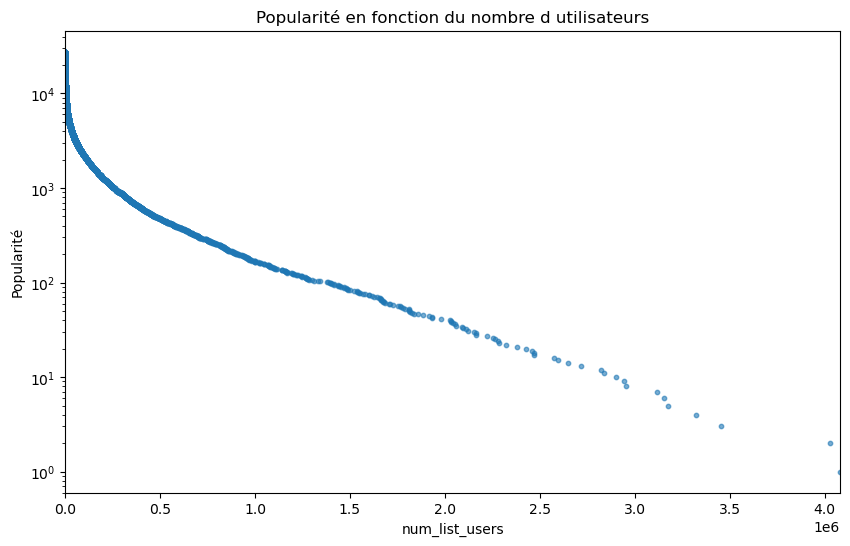

<Figure size 640x480 with 0 Axes>

In [76]:
#2/Popularité en fonction du nombre d'utilisateurs (qui ont regardé l'anime)
#Nous cherchons à déterminer la nature de la relation entre le nombre d'utilisateurs et la popularité des animes, car il est logique de supposer que ces deux variables sont liées.
plt.figure(figsize=(10, 6))
plt.scatter(anime_data['num_list_users'], anime_data['popularity'], alpha=0.6, s=10)
plt.xlim(0, anime_data['num_list_users'].max())
plt.title('Popularité (rang) en fonction du nombre d utilisateurs')
plt.xlabel('num_list_users')
plt.ylabel('Popularité (rang)')
plt.yscale('log') #échelle logarithmique
plt.show()
plt.savefig('Popularité&nbr_users.png')

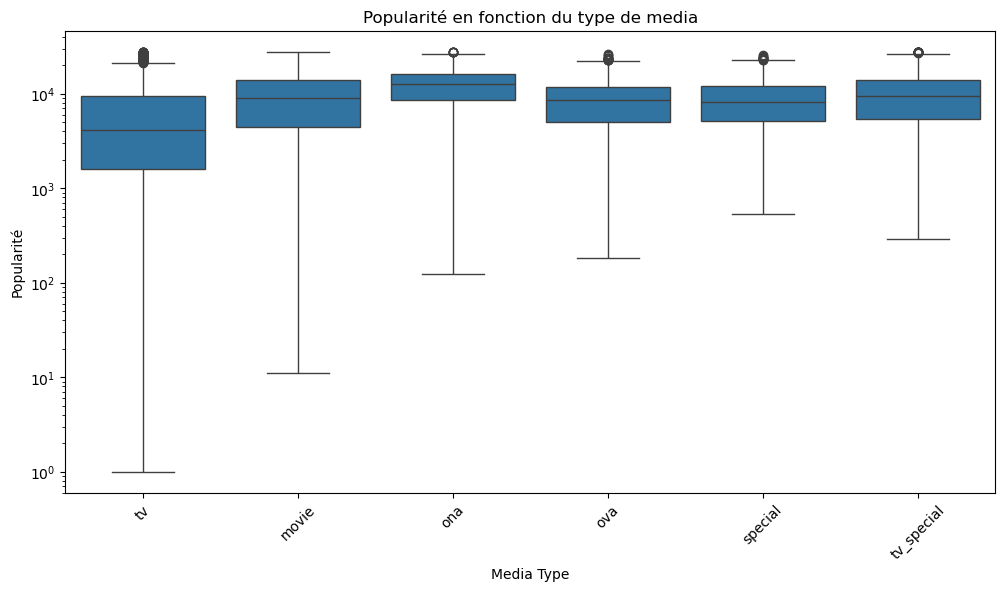

<Figure size 640x480 with 0 Axes>

In [77]:
#3/Popularité en fonction du type de média
plt.figure(figsize=(12, 6))
sns.boxplot(x=anime_data['media_type'], y=anime_data['popularity'], order=anime_data['media_type'].value_counts().index)
plt.title('Popularité (rang) en fonction du type de media')
plt.xlabel('Media Type')
plt.ylabel('Popularité (rang)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()
plt.savefig('Popularité&type.png')

<h1 style="font-size: 32px; color: green;">Partie III : Modélisation et prédictions à partir des classifieurs</h1>
<h1 style="font-size: 22px; color: blue;">1) Régression logistique multinomiale


In [78]:
# Nous commençons par importer les packages nécessaires pour l'apprentissage supervisé (classification ici)

import sklearn  
from sklearn.model_selection import train_test_split # sépare les données en échantillons de données d'apprentissage/de test aléatoires
from sklearn.linear_model import LogisticRegression # le modèle est une instance du modèle de régression logistique
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay #pour évaluer les performances du classifieur

# Pour mesurer le temps d'éxecution de la classification (comparer les modèles de classifications)
import time
time_start = time.time()

anime_data=anime_data.drop(columns=["ranking", "rating", "title", "source", "media_type", "status", "nsfw"])


In [79]:
# Maintenant, nous créons les différentes classes basées sur les valeurs de la variable popularity :

def popularity_multi(popularity):
    if popularity < 50:  # L'anime est très populaire.
        return 3  
    elif 50 <= popularity < 200:  # L'anime est assez populaire.
        return 2  
    elif 200 <= popularity < 500:  #L'anime est moyennement populaire.
        return 1  # 
    elif 500 <= popularity < 1000:  # L'anime est peu populaire.
        return 0 
    return 0  # Si aucune catégorie ne correspond (valeurs > 1000 ou autres cas). L'anime est très peu populaire.

# Les valeurs choisies sont arbitraires. L'intérêt étant de principalement distinguer les animes très populaires qui pourraient par exemple être mis plus avant ou immédiatement proposés aux utilisateurs ne l'ayant pas nécessairement vu.

In [80]:
# Préparation des exemples et des étiquettes :

# Nous commençons par remplacer la colonne "popularity" à l'aide des classes précédemment créer. Cette colonne contient donc des labels. 
# Ce seront, pour nos observations, les étiquettes.

anime_data['popularity_category'] = anime_data['popularity'].apply(popularity_multi)

# Exemples et étiquettes 
X = anime_data.drop(columns=['popularity', 'popularity_category'])  # Set de variables explicatives (exemples)
y = anime_data['popularity_category']  # Variable dépendante (étiquettes)


# On divise les données de manière aléatoire en données d'apprentissage (train) et de test :
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle=True)


# En général, le test correspond à 20 % des données et le train 80 %. 
# Si on rajoute des données de validation (k-folds), dans ce cas on prend plutôt 60% pour les données d'apprentissage, 20% pour les données de test et 20% pour les données de validation.
# L'argument random_state garantit la division aléatoire des données en test/train ainsi que la reproductibilité du code (mêmes arguments, conditions initiales (inputs) => mêmes outputs).
# L'argument Shuffle nous permet de mélanger les données pour éviter les biais liés à l'arrangement des données (les données ne sont pas temporelles ici).

# Pour finir, nous vérifions que toutes les classes sont présentes ...(1)
y_train_classes = y_train.unique()  #renvoie une liste avec les éléments de y_train mais avec UNE SEULE occurence par élément.
y_test_classes = y_test.unique()

# ...on corrige si ce n'est pas le cas (2) :
if len(set(y_train_classes) - set(y_test_classes)) > 0:
    y_test = pd.concat([y_test, pd.Series([y_train_classes[0]] * (len(y_train_classes) - len(y_test_classes)), index=y_test.index)])

In [81]:
# Passons au modèle. Commençons par initialiser le temps :
training_time = time.time()-time_start
print("Trainning time:", training_time)

# Modèle de classification par régressionb logistique multinomiale

model_lr = LogisticRegression(
    multi_class='multinomial',  #classification mutliclasses
    solver='lbfgs',
    max_iter=500
)

# L'argument "multi_class" indique que la régression multinomiale est utilisée.
# Au cours de la régression multi-nomiale, nous cherchons à minimiser la log-vraisemblance du modèle. C'est un problème d'optimisation.
# L'argument "solver" permet d'approximer le minimiseur à l'aide d'un algorithme de descente de gradient particulier, l'algorithme de quasi-Newton.
# L'idée, très grossièrement, est d'approximer H(xk), H(xk)(^-1), ou H(xk)^(-1) * grad(f(xk)) sans calculer les dérivées secondes.)
# (Ici, H(xk) fait référence à la matrice Hessienne à l'itération k, et f(xk) est le gradient à l'itération k.))
# L'argument max_iter donne le nombre maximum d'itération au cours desquelles l'algo tentera de minimiser la log-vraisemblance.
# Sa valeur dépend de la complexité du problème d'optimisation ainsi que du volume de l'ensemble des données.

Trainning time: 0.024862051010131836


In [82]:
# Entrainement du modèle
model_lr.fit(X_train, y_train)  # On associe les exemples aux étiquettes

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500, multi_class='multinomial')

In [83]:
# Données prédites par le modèle
y_pred = model_lr.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2812
           1       0.90      0.83      0.87        54
           2       0.70      0.82      0.75        28
           3       0.73      0.67      0.70        12

    accuracy                           0.99      2906
   macro avg       0.83      0.83      0.83      2906
weighted avg       0.99      0.99      0.99      2906



KeyboardInterrupt: 

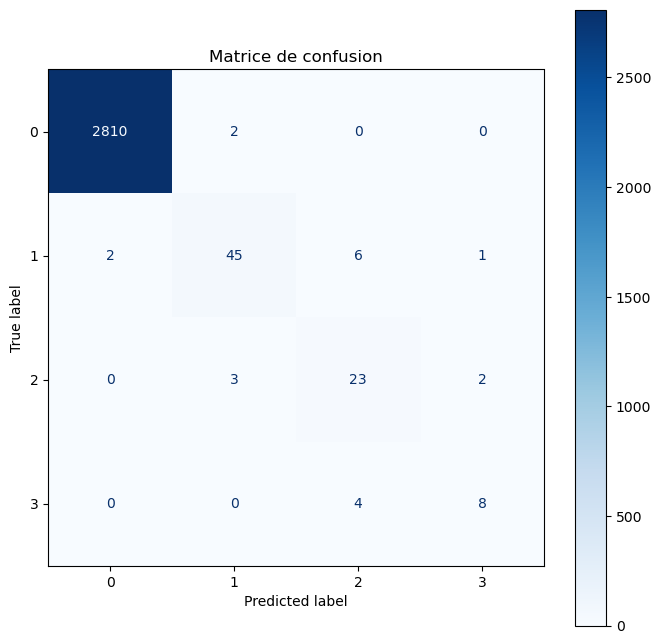

In [59]:
# Performances du classifieur
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lr.classes_)
disp.plot(cmap='Blues', ax=ax, colorbar=True)
plt.title("Matrice de confusion")
plt.savefig("matrice_de_confusion_pour_xbg.png")

# Courbe ROC et AUC (Area Under Curve)
y_pred_proba = model_lr.predict_proba(X_test)  # Prédictions sous forme de probabilités (pour pouvoir tracer la ROC curve)
auc_test = roc_auc_score(y_true=y_test, y_score=y_pred_proba, multi_class='ovr')
print("auc_test_LR", auc_test)

<h1 style="font-size: 22px; color: blue;">2) Régression LASSO


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [ ]:
# préparer notre dataframe
anime_data_l = pd.read_csv('anime_data.csv')

# création de la nouvelle target cible
anime_data_l['popularity_category'] = anime_data_l['popularity'].apply(categorize_popularity)

# Sélection des variables explicatives et de la nouvelle variable cible
X = anime_data_l[['num_episodes', 'num_scoring_users', 'source', 'status', 'nsfw', 'rating', 'media_type', 'average_episode_duration', 'start_year']]
y = anime_data_l['popularity_category']

# convertir les variables catégoriques en des variables numériques
categorical_features = ['source', 'status', 'nsfw', 'rating', 'media_type']
numeric_features = ['num_episodes', 'num_scoring_users', 'average_episode_duration', 'start_year']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='saga', max_iter=10000))
])


# Séparer les données en jeu d’entraînement et jeu de test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle

model.fit(X_train, y_train)

# Faire des prédictions sur le jeu de test

y_pred = model.predict(X_test)

In [ ]:
# Visualiser la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['impopulaire', 'peu populaire', 'Moyen', 'Populaire', 'Très populaire'], yticklabels=['impopulaire', 'peu populaire', 'Moyen', 'Populaire', 'Très populaire'])
plt.xlabel('predicted class')
plt.ylabel('actual class')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_defaultlambda.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#Maintenant on exécute le même code mais cette fois on teste différentes valeurs de l'hyperparamètre lambda afin de trouver celui qui donne les meilleurs résultats

from sklearn.model_selection import GridSearchCV

# préparer notre dataframe
anime_data_l = pd.read_csv('anime_data.csv')

anime_data_l['popularity_category'] = anime_data_l['popularity'].apply(categorize_popularity)
X = anime_data_l[['num_episodes', 'num_scoring_users', 'source', 'status', 'nsfw', 'rating', 'media_type', 'average_episode_duration', 'start_year']]
y = anime_data_l['popularity_category']
for column in X.select_dtypes(include=['float64', 'int64']).columns:
    X[column].fillna(X[column].median(), inplace=True)
for column in X.select_dtypes(include=['object']).columns:
    X[column].fillna(X[column].mode()[0], inplace=True)


categorical_features = ['source', 'status', 'nsfw', 'rating', 'media_type']
numeric_features = ['num_episodes', 'num_scoring_users', 'average_episode_duration', 'start_year']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='saga', max_iter=10000))
])

In [ ]:
# on utilise une distribution log pour balayer un plus grand champs de valeur
param_grid = {
    'classifier__C': np.logspace(-4, 4, 10)
}

# on fixe cv=4 et l'accuracy comme critère de selection
grid_search = GridSearchCV(pipeline, param_grid, cv=4, scoring='accuracy', verbose=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# On exécute les différents modèles
grid_search.fit(X_train, y_train)

# Récupération du meilleur modèle
best_model = grid_search.best_estimator_

# Prédiction
y_pred = best_model.predict(X_test)

In [ ]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Best C: {grid_search.best_params_['classifier__C']}")
print(f"Best model accuracy: {accuracy}")
print("Classification Report:")
print(report)

In [ ]:
# visualisation de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['impopulaire', 'peu populaire', 'Moyen', 'Populaire', 'Très populaire'], yticklabels=['impopulaire', 'peu populaire', 'Moyen', 'Populaire', 'Très populaire'])
plt.xlabel('predicted class')
plt.ylabel('actual class')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_grid_search.png', dpi=300, bbox_inches='tight')
plt.show()


<h1 style="font-size: 22px; color: blue;">3) Un modèle de Boosting : XGBoost (Extreme Gradient Boosting)


Contrairement aux modèles de régression logistique qui sont des modèles linéaires, les arbres de décision permettent de capturer et modéliser des **relations non linéaires** entre les variables explicatives et la variable dépendante. 
De plus, les arbres de décision sont moins sensibles aux **interactions** entre variables car on partitionne les données selon des critères de stratification sur certaines variables.
Enfin la **robustesse aux outliers**, **l'interprétation** de la prédiction et la gestion des **variables catégorielles** sont autant d'avantages qu'offrent l'utilisation d'un modèle basé sur des **arbres de décision**. 

Il existe extensions des modèles à arbres de décisions. Par exemple, nous avons **l'agrégation de modèles** comme les forêts aléatoires (chaque élément est un arbre). Nous avons également le **boosting** qui est une méthode utilisant plusieurs classifieurs faibles (typiquement des arbres de décisions). Plus précisément, ils se basent sur la somme pondérée de classifieurs faibles en ajustant successivement le poids des erreurs commises par les classifieurs précédents optimisant, de cette façon, la **robustesse** du modèle aux perturbations ainsi que la **précision**.

Ici, nous nous intéressant à **XGBoost** qui est une méthode de **boosting** au sein de laquelle on minimise la fonction de perte en se basant sur une approche de **gradient boosting** (on ajuste chaque nouveau modèle aux résidus du modèle précédent en calculant le gradient de la fonction de perte).


In [84]:
# Import des packages nécessaires
import xgboost as xgb

In [89]:
# Ici, seul le modèle change
model_xgb = xgb.XGBClassifier(
    objective='multi:softmax',  # classification mutliclasses 
    num_class=len(y.unique()),  # nombres de classes 
    use_label_encoder=False,    # on a déjà labelisé les éléments précédemment
    eval_metric='mlogloss'      # fonction de perte (perte logarithmique ici)
)

In [86]:
# Entrainement du modèle
model_xgb.fit(X_train, y_train)  # On associe les exemples aux étiquettes

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:23:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1733179675237/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

In [87]:
# Données prédites par le modèle
y_pred = model_xgb.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2644
           1       0.95      0.98      0.96        54
           2       0.96      0.86      0.91        29
           3       0.88      1.00      0.93        14

    accuracy                           1.00      2741
   macro avg       0.95      0.96      0.95      2741
weighted avg       1.00      1.00      1.00      2741

auc_test_XGB 0.9999076314506894


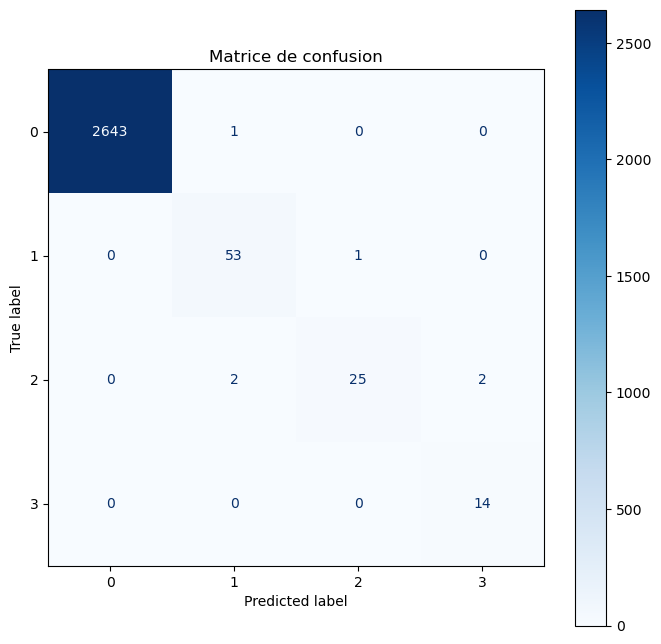

In [88]:
# Performances du classifieur
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
disp.plot(cmap='Blues', ax=ax, colorbar=True)
plt.title("Matrice de confusion")
plt.savefig("matrice_de_confusion_pour_xbg.png")

# Courbe ROC et AUC (Area Under Curve)
y_pred_proba = model_xgb.predict_proba(X_test)  # Prédictions sous forme de probabilités (pour pouvoir tracer la ROC curve)
auc_test = roc_auc_score(y_true=y_test, y_score=y_pred_proba, multi_class='ovr')
print("auc_test_XGB", auc_test)